In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyspark
from pyspark.sql import SparkSession
import pandas as pd
 
# creating the session
spark = SparkSession.builder.master("local").appName("Sentiment analysis of Amazon customer reviews").getOrCreate()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317145 sha256=3e3fce1f6dcc2856fe33f3c31bd95af2f77ab9b5595f7f66209196e6bcc18489
  Stored in directory: /root/.cache/pip/wheels/9f/34/a4/159aa12d0a510d5ff7c8f0220abbea42e5d81ecf588c4fd884
Successfully built pyspark


In [ ]:
data=spark.read.json('/content/drive/MyDrive/AMAZON_FASHION.json.gz')
data.printSchema()

root
 |-- asin: string (nullable = true)
 |-- image: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- style: struct (nullable = true)
 |    |-- Color:: string (nullable = true)
 |    |-- Format:: string (nullable = true)
 |    |-- Gem Type:: string (nullable = true)
 |    |-- Item Display Length:: string (nullable = true)
 |    |-- Item Package Quantity:: string (nullable = true)
 |    |-- Length:: string (nullable = true)
 |    |-- Material:: string (nullable = true)
 |    |-- Metal Type:: string (nullable = true)
 |    |-- Package Quantity:: string (nullable = true)
 |    |-- Scent Name:: string (nullable = true)
 |    |-- Shape:: string (nullable = true)
 |    |-- Size Name:: string (nullable = true)
 |    |-- Size:: string (nullable = true)
 |    |-

In [ ]:
data = data.select(['reviewText', 'overall'])

data.show()

+--------------------+-------+
|          reviewText|overall|
+--------------------+-------+
|Exactly what I ne...|    5.0|
|I agree with the ...|    2.0|
|Love these... I a...|    4.0|
| too tiny an opening|    2.0|
|                Okay|    3.0|
|Exactly what I wa...|    5.0|
|These little plas...|    4.0|
|mother - in - law...|    3.0|
|Item is of good q...|    3.0|
|I had used my las...|    3.0|
|This brand has be...|    4.0|
|I smoke 100's and...|    2.0|
|cheap and cheesy,...|    1.0|
|I ordered a ladie...|    1.0|
|Received the case...|    4.0|
|Love it but it to...|    3.0|
|I love it it is j...|    5.0|
|Quality product, ...|    5.0|
|I like it except ...|    4.0|
|It is smaller tha...|    3.0|
+--------------------+-------+
only showing top 20 rows



In [ ]:
data.groupby('overall').count().show()

+-------+------+
|overall| count|
+-------+------+
|    1.0|107080|
|    4.0|149331|
|    3.0| 97031|
|    2.0| 64718|
|    5.0|465476|
+-------+------+



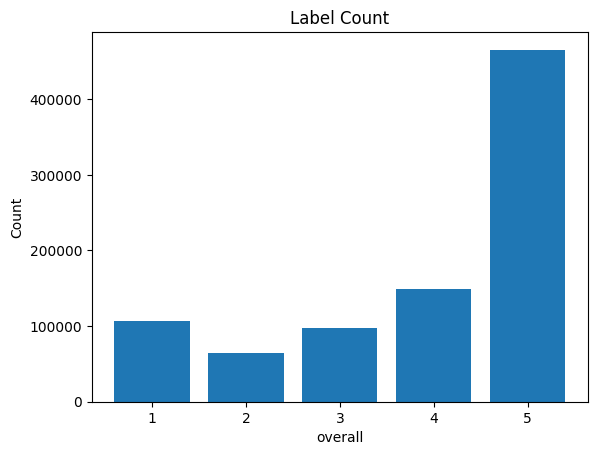

In [ ]:
import matplotlib.pyplot as plt

# Get label count
label_count = data.groupBy('overall').count().orderBy('overall').collect()

# Extract labels and counts
labels = [x['overall'] for x in label_count]
counts = [x['count'] for x in label_count]

# Plot bar chart
plt.bar(labels, counts)
plt.title('Label Count')
plt.xlabel('overall')
plt.ylabel('Count')
plt.show()

In [ ]:
#Checking if any null values are present
from pyspark.sql.functions import col,isnan, when, count
data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]
   ).show()

+----------+-------+
|reviewText|overall|
+----------+-------+
|      1233|      0|
+----------+-------+



In [ ]:
#Removed the null values
data = data.na.drop()
from pyspark.sql.functions import col,isnan, when, count
data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]
   ).show()

+----------+-------+
|reviewText|overall|
+----------+-------+
|         0|      0|
+----------+-------+



In [ ]:
df1=data
df1.show()

+--------------------+-------+
|          reviewText|overall|
+--------------------+-------+
|Exactly what I ne...|    5.0|
|I agree with the ...|    2.0|
|Love these... I a...|    4.0|
| too tiny an opening|    2.0|
|                Okay|    3.0|
|Exactly what I wa...|    5.0|
|These little plas...|    4.0|
|mother - in - law...|    3.0|
|Item is of good q...|    3.0|
|I had used my las...|    3.0|
|This brand has be...|    4.0|
|I smoke 100's and...|    2.0|
|cheap and cheesy,...|    1.0|
|I ordered a ladie...|    1.0|
|Received the case...|    4.0|
|Love it but it to...|    3.0|
|I love it it is j...|    5.0|
|Quality product, ...|    5.0|
|I like it except ...|    4.0|
|It is smaller tha...|    3.0|
+--------------------+-------+
only showing top 20 rows



In [ ]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer,IDF, StringIndexer
from pyspark.ml.classification import LogisticRegression

tokenizer = Tokenizer(inputCol="reviewText", outputCol="mytokens")

stopwords_remover=StopWordsRemover(inputCol="mytokens", outputCol="filtered")

count_vectorizer=CountVectorizer(inputCol="filtered",outputCol="rawfeatures")

idf=IDF(inputCol="rawfeatures",outputCol="vectorizedfeatures")



In [ ]:
labelEncoder=StringIndexer(inputCol="overall", outputCol="label").fit(data)

In [ ]:
labelEncoder.transform(data).show()

+--------------------+-------+-----+
|          reviewText|overall|label|
+--------------------+-------+-----+
|Exactly what I ne...|    5.0|  0.0|
|I agree with the ...|    2.0|  4.0|
|Love these... I a...|    4.0|  1.0|
| too tiny an opening|    2.0|  4.0|
|                Okay|    3.0|  3.0|
|Exactly what I wa...|    5.0|  0.0|
|These little plas...|    4.0|  1.0|
|mother - in - law...|    3.0|  3.0|
|Item is of good q...|    3.0|  3.0|
|I had used my las...|    3.0|  3.0|
|This brand has be...|    4.0|  1.0|
|I smoke 100's and...|    2.0|  4.0|
|cheap and cheesy,...|    1.0|  2.0|
|I ordered a ladie...|    1.0|  2.0|
|Received the case...|    4.0|  1.0|
|Love it but it to...|    3.0|  3.0|
|I love it it is j...|    5.0|  0.0|
|Quality product, ...|    5.0|  0.0|
|I like it except ...|    4.0|  1.0|
|It is smaller tha...|    3.0|  3.0|
+--------------------+-------+-----+
only showing top 20 rows



In [ ]:
labelEncoder.labels

['5.0', '4.0', '1.0', '3.0', '2.0']

In [ ]:
label_dict={'5.0':0.0, '4.0':1.0, '1.0':2.0, '3.0':3.0, '2.0':4.0}

In [ ]:
data=labelEncoder.transform(data)

In [ ]:
data.show()

+--------------------+-------+-----+
|          reviewText|overall|label|
+--------------------+-------+-----+
|Exactly what I ne...|    5.0|  0.0|
|I agree with the ...|    2.0|  4.0|
|Love these... I a...|    4.0|  1.0|
| too tiny an opening|    2.0|  4.0|
|                Okay|    3.0|  3.0|
|Exactly what I wa...|    5.0|  0.0|
|These little plas...|    4.0|  1.0|
|mother - in - law...|    3.0|  3.0|
|Item is of good q...|    3.0|  3.0|
|I had used my las...|    3.0|  3.0|
|This brand has be...|    4.0|  1.0|
|I smoke 100's and...|    2.0|  4.0|
|cheap and cheesy,...|    1.0|  2.0|
|I ordered a ladie...|    1.0|  2.0|
|Received the case...|    4.0|  1.0|
|Love it but it to...|    3.0|  3.0|
|I love it it is j...|    5.0|  0.0|
|Quality product, ...|    5.0|  0.0|
|I like it except ...|    4.0|  1.0|
|It is smaller tha...|    3.0|  3.0|
+--------------------+-------+-----+
only showing top 20 rows



In [ ]:
(trainingData, testData) = data.randomSplit([0.7, 0.3], seed = 42)

In [ ]:
trainingData.show()

+--------------------+-------+-----+
|          reviewText|overall|label|
+--------------------+-------+-----+
|                \n\n|    5.0|  0.0|
|          \n\n\n\n\n|    5.0|  0.0|
|       \n\n\n\n\n\nI|    5.0|  0.0|
|\n\n\n\n\nWeather...|    1.0|  2.0|
|\nI love it! Its ...|    5.0|  0.0|
|\nLove, love, lov...|    5.0|  0.0|
|                    |    5.0|  0.0|
|   \nonly 4 star ...|    4.0|  1.0|
|             ..  ...|    5.0|  0.0|
| Class Bangle bra...|    5.0|  0.0|
|                Cute|    4.0|  1.0|
| FIVE STARS!  CRE...|    5.0|  0.0|
|               Great|    5.0|  0.0|
| I don't like it,...|    1.0|  2.0|
| I love my new ri...|    5.0|  0.0|
|         I love them|    5.0|  0.0|
| I love them. Per...|    5.0|  0.0|
| I will order ant...|    5.0|  0.0|
| It is very small...|    1.0|  2.0|
|             Love it|    4.0|  1.0|
+--------------------+-------+-----+
only showing top 20 rows



In [ ]:
lr=LogisticRegression(featuresCol="vectorizedfeatures", labelCol="label")

In [ ]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[tokenizer, stopwords_remover, count_vectorizer, idf, lr])

In [ ]:
lr_model = pipeline.fit(trainingData)

In [ ]:
predictions=lr_model.transform(testData)

In [ ]:
predictions.show()

+--------------------+-------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|          reviewText|overall|label|            mytokens|            filtered|         rawfeatures|  vectorizedfeatures|       rawPrediction|         probability|prediction|
+--------------------+-------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|        \n\n\n\n\n\n|    5.0|  0.0|                  []|                  []|      (229010,[],[])|      (229010,[],[])|[0.83618343138774...|[0.41071882715568...|       0.0|
|\nLove the fabric...|    5.0|  0.0|[, love, the, fab...|[, love, fabric.,...|(229010,[0,1,573,...|(229010,[0,1,573,...|[5.45270898627488...|[0.93896301318921...|       0.0|
|        \nThank you!|    5.0|  0.0|     [, thank, you!]|     [, thank, you!]|(229010,[0,207,90...|(229010,[0,207,90...|[2.9734985

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
lrAccuracy = evaluator.evaluate(predictions)
print(lrAccuracy)

0.599857240137717


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
y_true=predictions.select('label')
y_true=y_true.toPandas()
y_pred=predictions.select('prediction')
y_pred=y_pred.toPandas()

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
cm=confusion_matrix(y_true,y_pred)
cm

array([[118188,  11527,   2617,   4770,   2002],
       [ 22870,  11892,   2045,   6017,   1823],
       [  3076,   1362,  20577,   3169,   4019],
       [  6807,   5348,   4722,   8706,   3326],
       [  2751,   1795,   7101,   4122,   3753]])

In [ ]:
class_names =['5.0', '4.0', '1.0', '3.0', '2.0']

Confusion matrix, without normalization
[[118188  11527   2617   4770   2002]
 [ 22870  11892   2045   6017   1823]
 [  3076   1362  20577   3169   4019]
 [  6807   5348   4722   8706   3326]
 [  2751   1795   7101   4122   3753]]


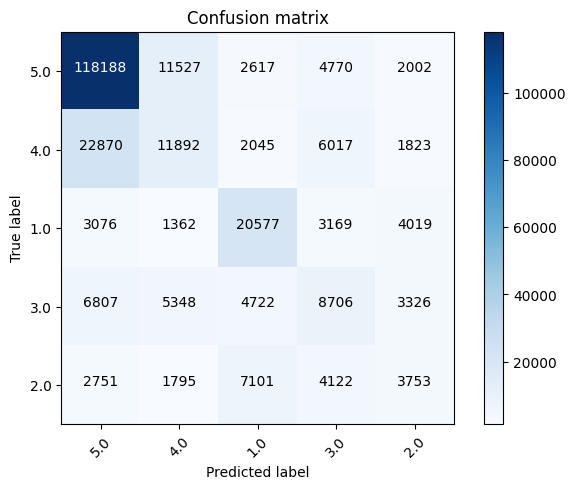

In [ ]:
plot_confusion_matrix(cm,class_names)

In [ ]:
from pyspark.sql.functions import when

# assume your DataFrame is called "df"
df1 = df1.withColumn("overall", when(df1.overall == 2, 3).otherwise(df1.overall))
df1.groupBy('overall').count().show()

+-------+------+
|overall| count|
+-------+------+
|    1.0|106984|
|    4.0|149169|
|    3.0|161659|
|    5.0|464591|
+-------+------+



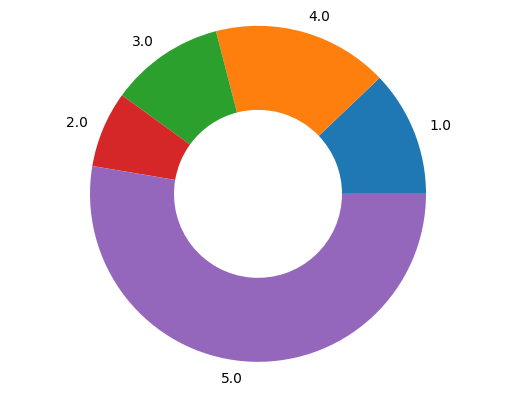

In [ ]:
import matplotlib.pyplot as plt

# Create a list of label counts
label_counts = data.groupBy('overall').count().collect()

# Extract labels and counts as separate lists
labels = [row['overall'] for row in label_counts]
counts = [row['count'] for row in label_counts]

# Create a donut chart
fig, ax = plt.subplots()
ax.pie(counts, labels=labels, wedgeprops=dict(width=0.5))
ax.axis('equal')
plt.show()

In [ ]:
df_class_5 = df1.filter(col("overall") == 5)
df_class_5.groupBy('overall').count().show()
df_class_5_sample = df_class_5.sample(False, 0.35) # 10% sampling rate, seed is optional

df1 = df1.filter(data.overall != 5)

df1 = df1.unionAll(df_class_5_sample)
df1.groupBy('overall').count().show()

+-------+------+
|overall| count|
+-------+------+
|    5.0|464591|
+-------+------+

+-------+------+
|overall| count|
+-------+------+
|    1.0|106984|
|    4.0|149169|
|    3.0|161659|
|    5.0|162382|
+-------+------+



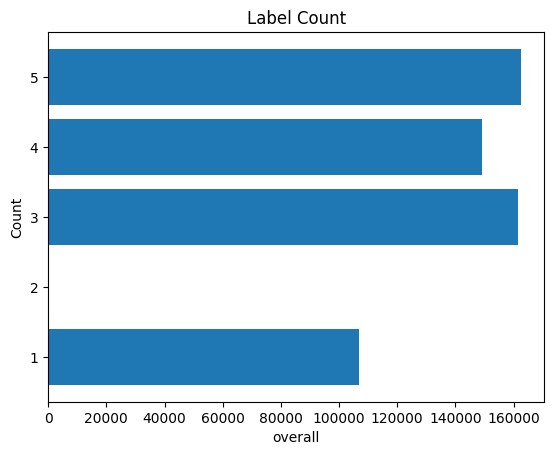

In [ ]:
import matplotlib.pyplot as plt

# Get label count
label_count = df1.groupBy('overall').count().orderBy('overall').collect()

# Extract labels and counts
labels = [x['overall'] for x in label_count]
counts = [x['count'] for x in label_count]

# Plot bar chart
plt.barh(labels, counts)
plt.title('Label Count')
plt.xlabel('overall')
plt.ylabel('Count')
plt.show()

In [ ]:
labelEncoder=StringIndexer(inputCol="overall", outputCol="label").fit(df1)

In [ ]:
labelEncoder.transform(df1).show()

+--------------------+-------+-----+
|          reviewText|overall|label|
+--------------------+-------+-----+
|I agree with the ...|    3.0|  1.0|
|Love these... I a...|    4.0|  2.0|
| too tiny an opening|    3.0|  1.0|
|                Okay|    3.0|  1.0|
|These little plas...|    4.0|  2.0|
|mother - in - law...|    3.0|  1.0|
|Item is of good q...|    3.0|  1.0|
|I had used my las...|    3.0|  1.0|
|This brand has be...|    4.0|  2.0|
|I smoke 100's and...|    3.0|  1.0|
|cheap and cheesy,...|    1.0|  3.0|
|I ordered a ladie...|    1.0|  3.0|
|Received the case...|    4.0|  2.0|
|Love it but it to...|    3.0|  1.0|
|I like it except ...|    4.0|  2.0|
|It is smaller tha...|    3.0|  1.0|
|Don't like it. It...|    1.0|  3.0|
|                love|    4.0|  2.0|
|Wonderful item. I...|    4.0|  2.0|
|made well but wil...|    4.0|  2.0|
+--------------------+-------+-----+
only showing top 20 rows



In [ ]:
labelEncoder.labels

['5.0', '3.0', '4.0', '1.0']

In [ ]:
df1=labelEncoder.transform(df1)

In [ ]:
(trainingData, testData) = df1.randomSplit([0.7, 0.3], seed = 42)

In [ ]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[tokenizer, stopwords_remover, count_vectorizer, idf, lr])

In [ ]:
lr_model = pipeline.fit(trainingData)

In [ ]:
predictions=lr_model.transform(testData)

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
lrAccuracy = evaluator.evaluate(predictions)
print(lrAccuracy)

0.5482771007185165


In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics

In [ ]:
lr_metric=MulticlassMetrics(predictions['label','prediction'].rdd)

/usr/local/lib/python3.9/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [ ]:
print("Accuracy:",lr_metric.accuracy)
print("Precision",lr_metric.precision(1.0))
print("Recall",lr_metric.recall(1.0))
print("F1Score",lr_metric.fMeasure(1.0))


Accuracy: 0.5497577488749548
Precision 0.5225691936182948
Recall 0.5058539119315911
F1Score 0.5140757134300479


In [ ]:
y_true=predictions.select('label')
y_true=y_true.toPandas()
y_pred=predictions.select('prediction')
y_pred=y_pred.toPandas()

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report

In [ ]:
cm=confusion_matrix(y_true,y_pred)

In [ ]:
cm

array([[32350,  4188, 10702,  1268],
       [ 3887, 25319,  9607,  9638],
       [13267, 10431, 19127,  1958],
       [ 1317, 10114,  1962, 18858]])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
class_names = ['5.0', '3.0', '4.0', '1.0']

Confusion matrix, without normalization
[[32350  4188 10702  1268]
 [ 3887 25319  9607  9638]
 [13267 10431 19127  1958]
 [ 1317 10114  1962 18858]]


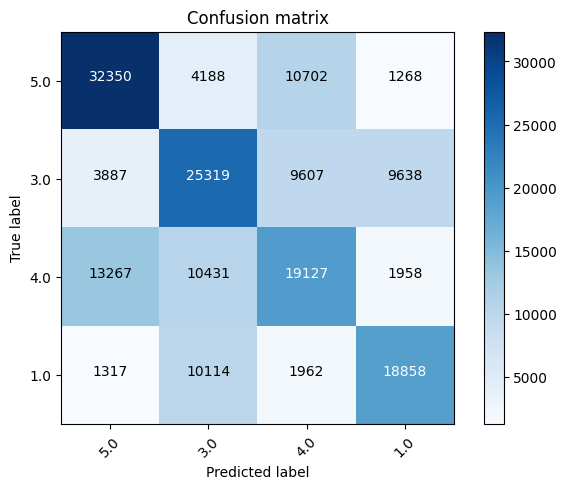

In [ ]:
plot_confusion_matrix(cm,class_names)

In [ ]:
# Classication Report
print(classification_report(y_true,y_pred,target_names=class_names))

              precision    recall  f1-score   support

         5.0       0.64      0.67      0.65     48508
         3.0       0.51      0.52      0.51     48451
         4.0       0.46      0.43      0.44     44783
         1.0       0.59      0.58      0.59     32251

    accuracy                           0.55    173993
   macro avg       0.55      0.55      0.55    173993
weighted avg       0.55      0.55      0.55    173993



In [ ]:
from pyspark.sql.types import StringType

In [ ]:
ex1 = spark.createDataFrame([
    ("I love the outfit",StringType())
],
# Column Name
["reviewText"]

)

In [ ]:
ex1.show()

+-----------------+---+
|       reviewText| _2|
+-----------------+---+
|I love the outfit| {}|
+-----------------+---+



In [ ]:
pred_ex1 = lr_model.transform(ex1)

In [ ]:
pred_ex1.show()

+-----------------+---+--------------------+--------------+--------------------+--------------------+--------------------+--------------------+----------+
|       reviewText| _2|            mytokens|      filtered|         rawfeatures|  vectorizedfeatures|       rawPrediction|         probability|prediction|
+-----------------+---+--------------------+--------------+--------------------+--------------------+--------------------+--------------------+----------+
|I love the outfit| {}|[i, love, the, ou...|[love, outfit]|(179018,[4,485],[...|(179018,[4,485],[...|[2.16190896640496...|[0.70313686613991...|       0.0|
+-----------------+---+--------------------+--------------+--------------------+--------------------+--------------------+--------------------+----------+



In [ ]:
pred_ex1.select('reviewText','rawPrediction','probability','prediction').show()

+-----------------+--------------------+--------------------+----------+
|       reviewText|       rawPrediction|         probability|prediction|
+-----------------+--------------------+--------------------+----------+
|I love the outfit|[2.16190896640496...|[0.70313686613991...|       0.0|
+-----------------+--------------------+--------------------+----------+



In [ ]:
class_names

['5.0', '3.0', '4.0', '1.0']

In [ ]:
ex1 = spark.createDataFrame([
    ("I like the outfit but the fabric is not good",StringType())
],
# Column Name
["reviewText"]

)

In [ ]:
ex1.show()

+--------------------+---+
|          reviewText| _2|
+--------------------+---+
|I like the outfit...| {}|
+--------------------+---+



In [ ]:
pred_ex1 = lr_model.transform(ex1)

In [ ]:
pred_ex1.select('reviewText','rawPrediction','probability','prediction').show()

+--------------------+--------------------+--------------------+----------+
|          reviewText|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+----------+
|I like the outfit...|[0.16751909638485...|[0.22563662120597...|       2.0|
+--------------------+--------------------+--------------------+----------+



In [ ]:
class_names

['5.0', '3.0', '4.0', '1.0']

In [ ]:
# Train the Random Forest classifier
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol="vectorizedfeatures", labelCol="label", numTrees=100)


In [ ]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[tokenizer, stopwords_remover, count_vectorizer, idf, rf])